# Plot results for Aintelope
Run these blocks for all tests, then scroll to the title you're interested in:


In [ ]:
%%capture
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import cm
import matplotlib.collections as mcoll
import matplotlib.path as mpath

from torch import Tensor

import dateutil.parser as dparser
import sys
import os
import seaborn as sns

from aintelope.training.dqn_training import load_checkpoint
from aintelope.training.dqn_training import Trainer
from aintelope.training.dqn_training import ReplayMemory

import aintelope.agents
from aintelope.agents import get_agent_class
from aintelope.agents import q_agent, instinct_agent

from aintelope.environments.savanna_gym import SavannaGymEnv
from aintelope.environments.savanna_zoo import SavannaZooSequentialEnv
from omegaconf import DictConfig, OmegaConf
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
import hydra
from hydra.core import global_hydra

In [ ]:
root_dir = os.path.split(os.path.split(os.getcwd())[0])[0]

if root_dir not in sys.path:
    sys.path.append(root_dir)

In [ ]:
# Paths and directories
outputs_dir = root_dir + "/outputs/"
available_records = os.listdir(outputs_dir)
print("Existing training runs", available_records)
conf_dir = root_dir + "/aintelope/config/config_experiment.yaml"

available_records = os.listdir(outputs_dir)
dirs = [
    os.path.join(outputs_dir, f) for f in available_records
]  # add path to each file
dirs.sort(key=lambda x: os.path.getmtime(x))
assert len(dirs) > 0, "No trainings have been run! make run-training* first"

# sort by experiment type (baseline/instinct)
global_hydra.GlobalHydra.instance().clear()
with initialize(version_base=None, config_path="../config"):
    # conf_dir = root_dir+'/aintelope/config/config_experiment.yaml'
    conf_dir = "config_experiment.yaml"
    cfg = compose(config_name=conf_dir, overrides=[])  # OmegaConf.load(conf_dir)
    cfg_base = compose(
        config_name=conf_dir,
        overrides=[
            "hparams.agent_id=q_agent",
            "hparams.agent_params.target_instincts=[]",
        ],
    )
    cfg_inst = compose(
        config_name=conf_dir,
        overrides=[
            "hparams.agent_id=instinct_agent",
            "hparams.agent_params.target_instincts=['smell']",
        ],
    )

models = {}
for exp_dir in dirs:
    dirr = "../../outputs/" + exp_dir.split("/")[-1] + "/hydra_logs/.hydra"
    # print(exp_dir)
    with initialize(version_base=None, config_path=dirr):  # "../config"
        conf_dir = "config.yaml"
        cfg = compose(config_name=conf_dir, overrides=[])
    mode = cfg.hparams.agent_id
    # print(mode)
    mod_dir = os.listdir(exp_dir + "/checkpoints/")
    runs_dir = [os.path.join(exp_dir + "/checkpoints/", m) for m in mod_dir]
    runs_dir.sort(key=lambda x: os.path.getmtime(x))
    if mode not in models:
        models[mode] = []
    models[mode].append(runs_dir)
# print(models)
latest_exp_dir = dirs[-1]  # arbitrary use of latest

print(available_records)

# Old plots
There might be an issue with env resets? The plots seem to have some jumps and multitude of grasspatches.

In [ ]:
print(latest_exp_dir)
print(dparser.parse(latest_exp_dir, fuzzy=True))
df = pd.read_csv(latest_exp_dir + "/memory_records.csv")
print(df.columns)

In [ ]:
from collections import namedtuple


keys = (
    ["agent_coords"]
    + [f"grass_patch_{i}" for i in range(cfg.hparams.env_params.amount_grass_patches)]
    + [f"water_hole_{i}" for i in range(cfg.hparams.env_params.amount_water_holes)]
)
StateTuple = namedtuple("StateTuple", {k: np.ndarray for k in keys})

x = []
y = []
event_x = []
event_y = []
event_type = []
food_x = []
food_y = []
water_x = []
water_y = []
for _, row in df.iterrows():
    state = eval(row["state"])
    # print(state)
    x.append(state[0][0])
    y.append(state[0][1])

    # refactor
    food_x.append(state[1][0])
    food_y.append(state[1][1])
    # food_x.append(state[2][0])
    # food_y.append(state[2][1])

    if row["instinct_events"] != "[]":
        event_x.append(x[-1])
        event_y.append(y[-1])
        event_type.append(row["instinct_events"])

In [ ]:
agent_df = pd.DataFrame(data={"x": x, "y": y})
print(agent_df.head(), len(agent_df))

food_df = pd.DataFrame(data={"x": food_x, "y": food_y})
print(food_df.head(), len(food_df))

# water_df = pd.DataFrame(data={'x':water_x, 'y':water_y})
# print(water_df.head(), len(water_df))

In [ ]:
event_df = pd.DataFrame(data={"x": event_x, "y": event_y, "event_type": event_type})
print(len(event_df))
print(event_df.head())

In [ ]:
plt.plot(agent_df["x"], agent_df["y"], ".r-")
plt.plot(food_df["x"], food_df["y"], ".g", markersize=15)
# plt.plot(water_df['x'], water_df['y'], '.b', markersize=15)
plt.show()

In [ ]:
# plot reward received over time
df["reward"].plot()

In [ ]:
color_map = "autumn"  # starts yellow, goes orange, then red
n_points = len(agent_df)

fig = plt.figure()
ax1 = fig.add_subplot(111)
cm = plt.get_cmap(color_map)
for i in range(10):
    ax1.set_prop_cycle("color", cm(np.linspace(0, 1, n_points - 1, endpoint=False)))
    for i in range(n_points - 1):
        plt.plot(agent_df["x"][i : i + 2], agent_df["y"][i : i + 2])
plt.plot(food_df["x"], food_df["y"], ".g", markersize=15)
# plt.plot(water_df['x'], water_df['y'], '.b', markersize=15)
plt.show()

# Valuemaps for actions
Note, these maps are new ones and don't correlate with the above ones as we randomly regenerate them.

In [ ]:
env = SavannaGymEnv(env_params=cfg.hparams.env_params)
env.reset()

action_space = env.action_space
observation, info = env.reset()
n_obs = observation.shape
model = load_checkpoint(
    models["q_agent"][-1][-1], n_obs, action_space.n
)  # latest with last model done.
trainer = Trainer(cfg)
agent_id = "agent_0"
agent = get_agent_class(cfg.hparams.agent_id)(
    agent_id,
    trainer,
    **cfg.hparams.agent_params,
)
# move the agent into each square and ask for its values for each action, then add that direction into the map
valuemap = np.zeros((env.metadata["map_max"] + 2, env.metadata["map_max"] + 2, 4))

ACTION_MAP = np.array(
    [[0, 1], [1, 0], [0, -1], [-1, 0]]
)  # This is a copy from savanna.py, should be an accessible param
for x in range(0, env.metadata["map_max"]):
    for y in range(0, env.metadata["map_max"]):
        if (env.grass_patches == [x, y]).all(1).any():
            continue
        if (env.water_holes == [x, y]).all(1).any():
            continue
        env.set_agent_position(agent, np.array([x, y]))
        observation = env.observe(agent)
        # print(env.agent_states[agent])
        action_vals = model(Tensor(observation)).detach().numpy()
        offset = ACTION_MAP
        for action in range(len(ACTION_MAP)):
            x_ = offset[action][0] + x
            y_ = offset[action][1] + y
            valuemap[x_, y_, action] = action_vals[action]

valuemap = np.sum(valuemap, 2) / len(ACTION_MAP)

# print(valuemap)

In [ ]:
sns.heatmap(valuemap[1:-1, 1:-1])

In [ ]:
# env.render() isnt working atm
maps = np.zeros((env.metadata["map_max"], env.metadata["map_max"]))
for grs in env.grass_patches:
    print(grs[0])
    maps[int(grs[0]), int(grs[1])] = 1.0
for wtr in env.water_holes:
    maps[int(wtr[0]), int(wtr[1])] = 2.0
sns.heatmap(maps)
# RED FOOD, LIGHT water

In [ ]:
env.set_agent_position(agent, np.array([2, 2]))
observation = env.observe(agent)
action_vals = model(Tensor(observation)).detach().numpy()
print(action_vals)

# Model performance plots
These plots don't have the exploration bonus as confabulators (such as epsilon-greedy).

Train the model N times, then change n_latest to this N and run the block.

In [ ]:
def testrun(model, env, test_cfg, samples, test_length):
    # Run each model for 10 different resets, with 10 different locations on the map.
    # Gather the cumulative reward, -1 has to be given on each step though
    # Or reset each time the food is found?

    env.reset()
    trainer = Trainer(cfg)
    agent_id = "agent_0"
    observation = env.observe(agent_id)
    agent = get_agent_class(cfg.hparams.agent_id)(
        agent_id,
        trainer,
        **cfg.hparams.agent_params,
    )
    trainer.add_agent(agent_id, observation.shape, env.action_space)
    coords = np.arange(env.metadata["map_min"], env.metadata["map_max"], 1)
    start_pos = np.random.choice(coords, size=(samples, 2))
    scores = []
    rewards = []
    for j in range(start_pos.shape[0]):
        env.reset()
        agent.reset(env.observe(agent.id))
        env.set_agent_position(agent, np.array(start_pos[j]))
        for i in range(test_length):
            observation = env.observe(agent.id)
            action = agent.get_action(observation, 0)

            observation, score, terminateds, truncateds, _ = env.step(action)
            reward = agent.update(env, observation, score, False)
            rewards.append(reward)
            scores.append(score)

    return scores, rewards, agent

In [ ]:
# Load the models from checkpoints and run them through test envs to measure their performance
# without training parameters (usually exploration, like epsilon). statistical significance per run
def calc_results_per_model(models, test_cfg):  # test_dirs
    samples = 10  # how many times a random start location is attempted
    test_length = 20  # how long time to find grass

    env = SavannaZooSequentialEnv(env_params=test_cfg.hparams.env_params)
    env.reset()
    observation = env.observe("agent_0")
    n_actions = env.action_space("agent_0").n
    n_obs = observation.shape
    scores = np.zeros([len(models[0]), len(models), samples * test_length])
    rewards = np.zeros([len(models[0]), len(models), samples * test_length])
    for i in range(len(models)):  # different runs for statistical significance
        for j in range(len(models[0])):  # model as epochs progress
            model = load_checkpoint(models[i][j], n_obs, n_actions)
            model.eval()
            # run model
            score, reward, agent = testrun(model, env, test_cfg, samples, test_length)
            scores[j, i, :] = score
            rewards[j, i, :] = reward
    return scores, rewards, agent

In [ ]:
# %%capture
# Style | epoch x 4-corners x repetition
# Two np arrays with [10,4,10] dimensions
# Style=baseline or instinct, 4-corners is in above the different starting positions
# (i.e. statistical stability) and repetitions is for all the folders ya made, (stat stab)

# Split directories here for which ones in outputs are from instinct and which are baseline
base_dirs = models["q_agent"]
inst_dirs = models["instinct_agent"]

b_scores, b_rewards, b_agent = calc_results_per_model(base_dirs, cfg_base)
i_scores, i_rewards, i_agent = calc_results_per_model(inst_dirs, cfg_inst)

In [ ]:
def combine_dims(a, start=0, count=2):
    """Reshapes numpy array a by combining count dimensions,
    starting at dimension index start"""
    s = a.shape
    return np.reshape(a, s[:start] + (-1,) + s[start + count :])


print(b_scores.shape, b_rewards.shape)
print(i_scores.shape, i_rewards.shape)
print(b_agent, i_agent)
print(b_rewards.shape)
""" As discrete datapoints, epoch x model_run x (starts + test_length)
b_s = combine_dims(b_scores[0:-1,:,:],1).T
b_r = combine_dims(b_rewards[0:-1,:,:],1).T
i_s = combine_dims(i_scores[0:-1,:,:],1).T
i_r = combine_dims(i_rewards[0:-1,:,:],1).T
"""
b_s = np.mean(b_scores, axis=2).T
b_r = np.mean(b_rewards, axis=2).T
i_s = np.mean(i_scores, axis=2).T
i_r = np.mean(i_rewards, axis=2).T
# print(b_r, i_r)

In [ ]:
# Plot results
X = np.arange(1, b_scores.shape[0] + 1)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharey=True)
axs[0].boxplot(b_r, labels=X)
axs[0].set_title("Baseline")

axs[1].boxplot(i_r, labels=X)
axs[1].set_title("Instinct")

# plt.boxplot(i_r, labels=X)
# plt.boxplot(i_r, labels=X)

plt.xlabel("Epoch")
plt.ylabel("Reward")
# plt.title("Reward comparison")
plt.legend()
plt.show()

In [ ]:
# Score results

b_mean = b_s.flatten()
i_mean = i_s.flatten()
if b_s.shape[0] > 1:
    b_mean = np.mean(b_s, axis=0)
if i_s.shape[0] > 1:
    i_mean = np.mean(i_s, axis=0)

X = np.arange(1, b_scores.shape[0] + 1)

plt.plot(X, b_mean, color="r", label="baseline")
plt.plot(X, i_mean, color="g", label="instinct")

plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Score comparison")
plt.legend()
plt.show()

In [ ]:
# Add statsign boxes
# figure out what the rewards should be from agent
# figure out what the score should be
# do 10 epochs
# https://matplotlib.org/3.1.1/gallery/statistics/boxplot.html

In [ ]:
import numpy as np

print(type(np.zeros(4).shape))

In [ ]:
import pandas as pd

a = [[1, 2], [2, 3]]
b = [[1, 1], [12, 31]]
df = pd.DataFrame(a, columns=["R", "S"])
dff = pd.DataFrame(b, columns=["R", "S"])

names = [1, 11]
frames = [df, dff]
# for i in range(5):
#    names.append(i)
s = pd.concat([df, dff], names)
# ff = pd.MultiIndex([df,dff],names=df.columns)

# print(s)

In [ ]:
import numpy as np

a = np.ones((2, 2, 2))
b = pd.MultiIndex(a)
print(b)
print(b.shape)

In [ ]:
keys = ["run", "ag", "r"]
data = {
    "run": [1, 1, 2, 2, 3, 3],
    "ag": [1, 2, 1, 2, 1, 2],
    "r": [2, 3, 1, 4, 7, 8],
    "s": [2, 3, 1, 4, 7, 8],
}
df = pd.DataFrame(data=data)
# d = {'col1': [1, 2], 'col2': [3, 4], 'col3': [3,3]}

# df = pd.DataFrame(data=d)
print(df)
# print(data,d)

In [ ]:
df.groupby(["ag"])["r", "s"].mean()

In [ ]:
import plotting
import numpy as np
import pandas as pd
import recording
from pathlib import Path
import matplotlib.pyplot as plt

In [ ]:
record_path = "/home/joel/project/aintelope/outputs/20240214180755/"
events_filename = "events.csv"
events = recording.read_events(
    "/home/joel/project/aintelope/outputs/20240214180755/", "events.csv"
)

In [ ]:
events = []

for path in Path(record_path).rglob(events_filename):
    print(path)
    events.append(pd.read_csv(path))

In [ ]:
ss = plotting.plot_performance(events, ".")

In [ ]:
keys = ["Run_id", "Episode", "Agent_id", "Reward", "Score"]
data = pd.DataFrame(columns=keys)
for event in events:
    data = pd.concat([data, event[keys]])
dd = data.groupby(["Episode", "Agent_id"]).mean()
print(dd)

In [ ]:
"""
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharey=True)
axs[0].boxplot(b_r, labels=X)
axs[0].set_title("Baseline")

axs[1].boxplot(i_r, labels=X)
axs[1].set_title("Instinct")

plt.boxplot(i_r, labels=X)
plt.boxplot(i_r, labels=X)

plt.xlabel("Epoch")
plt.ylabel("Reward")
# plt.title("Reward comparison")
plt.legend()
plt.show()
"""

fig = plt.figure()
plt.plot(dd[["Reward", "Score"]].to_numpy())
plt.xlabel("Episode")
plt.ylabel("Mean Reward")
plt.legend("RS")
plt.show()

# Fix steps so that it geos 1...1000 instead of 1..200 1..200
# This is what learning is
# There's no model reset between test1 and test2 btw...

In [ ]:
dd[["Reward", "Score"]]

/home/joel/project/aintelope/aintelope/analytics/plotting.py:39: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plots = data.groupby(["Episode", "Agent_id"]).mean()


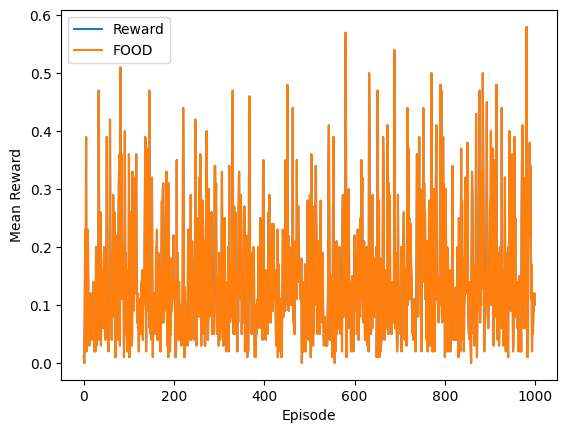

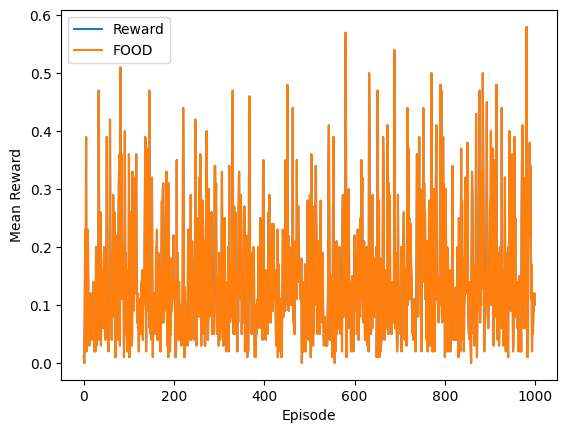

In [3]:
import os

import plotting, recording

score_dimensions = ["FOOD"]  # get_score_dimensions(cfg)
experiment_dir = os.path.normpath(
    "/home/joel/project/aintelope/outputs/broke/food_5x5/"
)
events_fname = os.path.normpath("events.csv")

savepath = os.path.join(experiment_dir, "_plot.png")
events = recording.read_events(experiment_dir, events_fname)
plotting.plot_performance(events, score_dimensions, savepath)